In [1]:
import tensorflow as tf

In [2]:
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import shutil

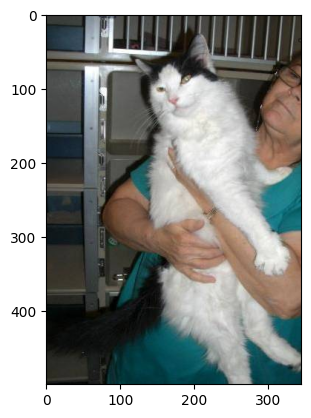

In [3]:
# look at an image for fun
plt.imshow(image.load_img('./dogs-vs-cats/train/cat.25.jpg'))
plt.show()

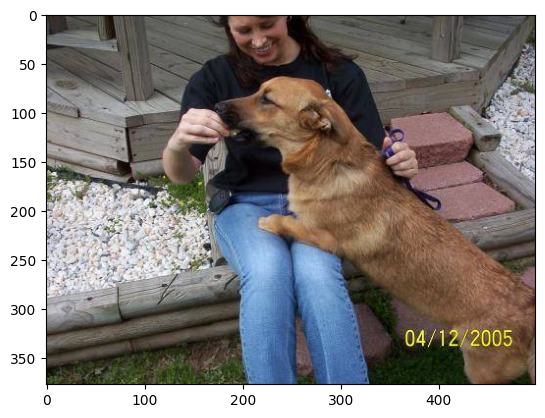

In [4]:
# Food images start with 1, non-food images start with 0
plt.imshow(image.load_img('./dogs-vs-cats/train/dog.52.jpg'))
plt.show()

In [5]:
if os.path.exists('./data'):
  shutil.rmtree('./data')

In [6]:
paths = ['./data', './data/train', './data/train/dogs', './data/train/cats', './data/test', './data/test/dogs', './data/test/cats']

for path in paths:
  if not os.path.exists(path):
    os.mkdir(path)


In [7]:
for (dirpath, dirnames, filenames) in os.walk('./dogs-vs-cats'):
  dirpath = dirpath.replace("\\","/")
  cat_array = [x for x in filenames if 'cat' in x]
  dog_array = [x for x in filenames if 'dog' in x]

  if (len(cat_array) == len(dog_array) and len(cat_array) > 0 and len(dog_array) > 0):
    for i in range(len(cat_array)):
      if i < 10000:
        shutil.copyfile(f"{dirpath}/{cat_array[i]}", f"./data/train/cats/{cat_array[i]}")
        shutil.copyfile(f"{dirpath}/{dog_array[i]}", f"./data/train/dogs/{dog_array[i]}")
      else:
        shutil.copyfile(f"{dirpath}/{cat_array[i]}", f"./data/test/cats/{cat_array[i]}")
        shutil.copyfile(f"{dirpath}/{dog_array[i]}", f"./data/test/dogs/{dog_array[i]}")


In [8]:
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

In [9]:
train_path = './data/train'
test_path = './data/test'

In [10]:
# useful for getting number of files
train_image_files = glob(train_path + '/*/*.jpg')
test_image_files = glob(test_path + '/*/*.jpg')

In [11]:
folders = glob(train_path + '/*')
folders

['./data/train\\cats', './data/train\\dogs']

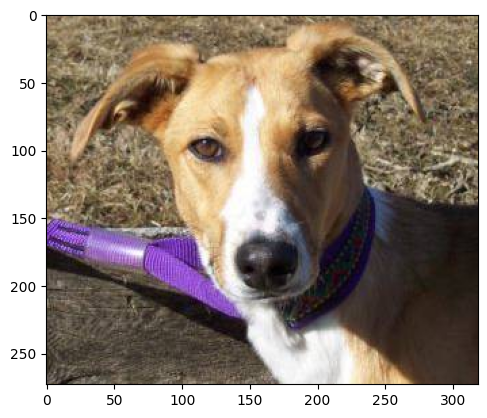

In [12]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(train_image_files)))
plt.show()

In [13]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

In [14]:
# freeze pretrained model weights
ptm.trainable = False

In [15]:
# map the data into feature vectors

# Keras image data generator returns classes one-hot encoded

K = len(folders) # number of classes
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [16]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [17]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [18]:
# create an instance of ImageDataGenerator
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [19]:
batch_size = 32

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
test_generator = gen_test.flow_from_directory(
  test_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [20]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [21]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=test_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(train_image_files) / batch_size)),
  validation_steps=int(np.ceil(len(test_image_files) / batch_size)),
)

C:\Users\danbl\AppData\Local\Temp\ipykernel_36700\3274616107.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/10
625/625 [==============================] - 223s 352ms/step - loss: 1.6197 - accuracy: 0.9549 - val_loss: 1.8642 - val_accuracy: 0.9690
Epoch 2/10
625/625 [==============================] - 124s 198ms/step - loss: 1.6289 - accuracy: 0.9704 - val_loss: 1.5770 - val_accuracy: 0.9756
Epoch 3/10
625/625 [==============================] - 123s 197ms/step - loss: 1.9661 - accuracy: 0.9730 - val_loss: 2.2662 - val_accuracy: 0.9764
Epoch 4/10
625/625 [==============================] - 124s 199ms/step - loss: 1.7755 - accuracy: 0.9749 - val_loss: 3.0745 - val_accuracy: 0.9732
Epoch 5/10
625/625 [==============================] - 124s 198ms/step - loss: 2.0247 - accuracy: 0.9758 - val_loss: 2.4968 - val_accuracy: 0.9782
Epoch 6/10
625/625 [==============================] - 125s 199ms/step - loss: 1.9009 - accuracy: 0.9773 - val_loss: 2.7510 - val_accuracy: 0.9766
Epoch 7/10
625/625 [==============================] - 125s 200ms/step - loss: 1.9908 - accuracy: 0.9779 - val_loss: 2.7485 -

In [22]:
# create a 2nd train generator which does not use data augmentation
# to get the true train accuracy
train_generator2 = gen_test.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
model.evaluate_generator(
    train_generator2,
    steps=int(np.ceil(len(train_image_files) / batch_size)))

Found 20000 images belonging to 2 classes.


C:\Users\danbl\AppData\Local\Temp\ipykernel_36700\1850897713.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(


[0.8910245895385742, 0.991100013256073]

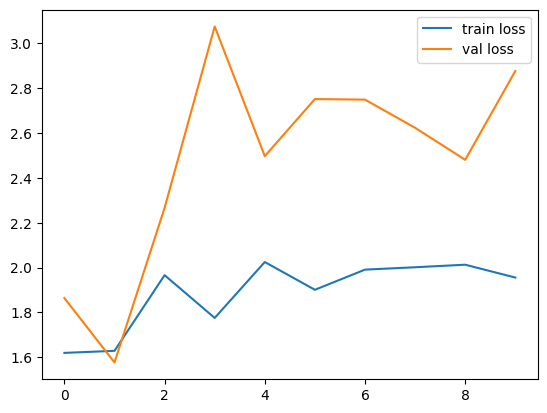

In [23]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

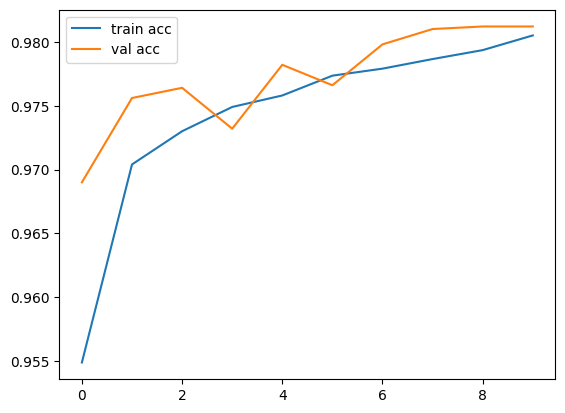

In [24]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()